https://huggingface.co/transformers/model_doc/bert.html

https://www.reddit.com/r/MLQuestions/comments/e8kyc3/finetuning_bert_for_a_regression_task/

https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

https://d2l.ai/chapter_preface/index.html

https://towardsdatascience.com/how-to-fine-tune-bert-with-pytorch-lightning-ba3ad2f928d2

https://github.com/sobamchan/pytorch-lightning-transformers/blob/master/csqa.py

https://mccormickml.com/2019/07/22/BERT-fine-tuning/

https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX

https://discuss.huggingface.co/t/which-loss-function-in-bertforsequenceclassification-regression/1432/3


# Content <a id='home'></a>
## [2. Loading the Dataset](#ltd)
## [3. Data Preprocessing](#dp)
## [4. Fine Tuning Bert](#ftb)
## [5. Test set](#ts)

In [1]:
#!pip install seaborn

# [1. Loading the dataset](#ltd)

In [2]:
import torch
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
import numpy as np
from sklearn.metrics import mean_squared_error
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import seaborn as sns
import pickle
#os.environ["CUDA_VISIBLE_DEVICES"]="3"

C:\Users\amin\anaconda3\envs\hugging\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [4]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080 Ti


In [5]:
# device = torch.device('cuda:1')
# print(device)

# 2. loading the dataset <a id='ltd'></a>
[home](#home)

In [13]:
MergedData = pd.read_csv('./ProcessedData/Proc_AllMergedData.txt')
MergedData.head(2)

,ID,post_text,truth_class,truth_mean,target_description,target_paragraphs,first_par,favorite_count,retweet_count,created_at,...,user_url,author_name,author_friends_count,users_followers_count_median,outlier_flagged,fav_count_over_followers,Ptarget_paragraphs,Ptarget_description,Ppost_text,Pfirst_par
0,799360299060989952,"Are high-end, big-budget films the future of f...",NaN,NaN,"Freida Pinto, Allison Williams, Kuoth Wiel are...",Is David O. Russell's Prada short film the fu...,Is David O. Russell's Prada short film the fut...,6,4,2016-11-17 21:15:21,...,http://t.co/7xDl0vVHSt,USA TODAY,622,3995738.0,0,0.000002,Is David O. Russell's Prada short film the fu...,"Freida Pinto, Allison Williams, Kuoth Wiel are...","Are high-end, big-budget films the future of f...",Is David O. Russell's Prada short film the fut...
1,801903772805042180,India has more than its cash crisis to worry a...,NaN,NaN,India's Cash Crisis Isn't Modi's Only Headache...,Connecting decision makers to a dynamic netwo...,Connecting decision makers to a dynamic networ...,8,15,2016-11-24 21:42:12,...,http://t.co/YFISwy1upH,Bloomberg,1271,5932478.0,0,0.000001,Connecting decision makers to a dynamic netwo...,India's Cash Crisis Isn't Modi's Only Headache...,India has more than its cash crisis to worry a...,Connecting decision makers to a dynamic networ...


In [14]:
costum_cols = ['ID' ,'favorite_count','retweet_count', 'created_at','favorited','retweeted','users_followers_count','user_name', 'user_description', 'user_url', 'author_name',
       'author_friends_count']
MergedData[costum_cols].head(1)

,ID,favorite_count,retweet_count,created_at,favorited,retweeted,users_followers_count,user_name,user_description,user_url,author_name,author_friends_count
0,799360299060989952,6,4,2016-11-17 21:15:21,False,False,3995467,USA TODAY,The latest news and most interesting stories f...,http://t.co/7xDl0vVHSt,USA TODAY,622


In [15]:
MergedData['user_name'].nunique()

28

In [16]:
MergedData.columns

Index(['ID', 'post_text', 'truth_class', 'truth_mean', 'target_description',
       'target_paragraphs', 'first_par', 'favorite_count', 'retweet_count',
       'created_at', 'favorited', 'retweeted', 'users_followers_count',
       'user_name', 'user_description', 'user_url', 'author_name',
       'author_friends_count', 'users_followers_count_median',
       'outlier_flagged', 'fav_count_over_followers', 'Ptarget_paragraphs',
       'Ptarget_description', 'Ppost_text', 'Pfirst_par'],
      dtype='object')

In [17]:
print(len(MergedData))
print(len(MergedData[MergedData['outlier_flagged'] == 1]))

101893
19986


In [18]:
MergedData['post_null'] =  MergedData['post_text'].isna()
MergedData.head(2)

,ID,post_text,truth_class,truth_mean,target_description,target_paragraphs,first_par,favorite_count,retweet_count,created_at,...,author_name,author_friends_count,users_followers_count_median,outlier_flagged,fav_count_over_followers,Ptarget_paragraphs,Ptarget_description,Ppost_text,Pfirst_par,post_null
0,799360299060989952,"Are high-end, big-budget films the future of f...",NaN,NaN,"Freida Pinto, Allison Williams, Kuoth Wiel are...",Is David O. Russell's Prada short film the fu...,Is David O. Russell's Prada short film the fut...,6,4,2016-11-17 21:15:21,...,USA TODAY,622,3995738.0,0,0.000002,Is David O. Russell's Prada short film the fu...,"Freida Pinto, Allison Williams, Kuoth Wiel are...","Are high-end, big-budget films the future of f...",Is David O. Russell's Prada short film the fut...,False
1,801903772805042180,India has more than its cash crisis to worry a...,NaN,NaN,India's Cash Crisis Isn't Modi's Only Headache...,Connecting decision makers to a dynamic netwo...,Connecting decision makers to a dynamic networ...,8,15,2016-11-24 21:42:12,...,Bloomberg,1271,5932478.0,0,0.000001,Connecting decision makers to a dynamic netwo...,India's Cash Crisis Isn't Modi's Only Headache...,India has more than its cash crisis to worry a...,Connecting decision makers to a dynamic networ...,False


In [19]:
CleanData = MergedData[MergedData['outlier_flagged'] == 0].copy()
print(len(CleanData))
CleanData = CleanData[CleanData['post_null'] == False]
print(len(CleanData))

81907
81861


In [20]:
CleanData.head(2)
#CleanData = CleanData.head(1024).copy()

,ID,post_text,truth_class,truth_mean,target_description,target_paragraphs,first_par,favorite_count,retweet_count,created_at,...,author_name,author_friends_count,users_followers_count_median,outlier_flagged,fav_count_over_followers,Ptarget_paragraphs,Ptarget_description,Ppost_text,Pfirst_par,post_null
0,799360299060989952,"Are high-end, big-budget films the future of f...",NaN,NaN,"Freida Pinto, Allison Williams, Kuoth Wiel are...",Is David O. Russell's Prada short film the fu...,Is David O. Russell's Prada short film the fut...,6,4,2016-11-17 21:15:21,...,USA TODAY,622,3995738.0,0,0.000002,Is David O. Russell's Prada short film the fu...,"Freida Pinto, Allison Williams, Kuoth Wiel are...","Are high-end, big-budget films the future of f...",Is David O. Russell's Prada short film the fut...,False
1,801903772805042180,India has more than its cash crisis to worry a...,NaN,NaN,India's Cash Crisis Isn't Modi's Only Headache...,Connecting decision makers to a dynamic netwo...,Connecting decision makers to a dynamic networ...,8,15,2016-11-24 21:42:12,...,Bloomberg,1271,5932478.0,0,0.000001,Connecting decision makers to a dynamic netwo...,India's Cash Crisis Isn't Modi's Only Headache...,India has more than its cash crisis to worry a...,Connecting decision makers to a dynamic networ...,False


<AxesSubplot:title={'center':'favorite_count'}, xlabel='author_name'>

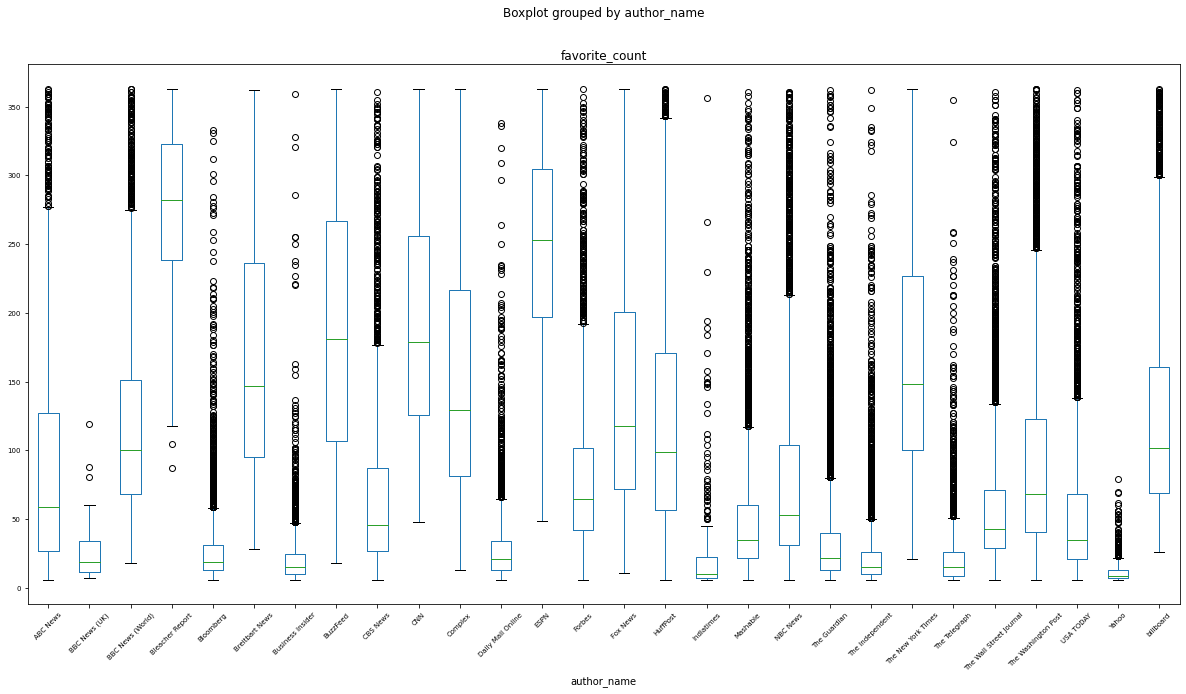

In [21]:
CleanData.boxplot(by = 'author_name'
                    , column =['favorite_count']
                    , grid = False
                    ,rot = 45
                    ,fontsize='x-small'
                   ,figsize=(20,10))

In [22]:
CleanData.groupby('author_name')['ID'].count()

author_name
ABC News                   1928
BBC News (UK)                44
BBC News (World)           3064
Bleacher Report              83
Bloomberg                  4988
Breitbart News              570
Business Insider           2770
BuzzFeed                   1611
CBS News                   2768
CNN                        1592
Complex                     574
Daily Mail Online          3035
ESPN                        843
Forbes                     3009
Fox News                   1865
HuffPost                   3170
Indiatimes                  296
Mashable                   5143
NBC News                   4085
The Guardian               8336
The Independent            6289
The New York Times         2791
The Telegraph              3788
The Wall Street Journal    5256
The Washington Post        5039
USA TODAY                  3692
Yahoo                      1946
billboard                  3286
Name: ID, dtype: int64

In [23]:
TheGuardian = CleanData[CleanData['author_name'] == 'The Guardian']
len(TheGuardian)

8336

In [24]:
TheGuardian.head(5)

,ID,post_text,truth_class,truth_mean,target_description,target_paragraphs,first_par,favorite_count,retweet_count,created_at,...,author_name,author_friends_count,users_followers_count_median,outlier_flagged,fav_count_over_followers,Ptarget_paragraphs,Ptarget_description,Ppost_text,Pfirst_par,post_null
9,793428731213774849,Manchester United must address Zlatan Ibrahimo...,NaN,NaN,Manchester United must address Zlatan Ibrahimo...,Zlatan Ibrahimovic has not scored for Manches...,Zlatan Ibrahimovic has not scored for Manchest...,12,11,2016-11-01 12:25:25,...,The Guardian,1083,8400566.0,0,0.000001,Zlatan Ibrahimovic has not scored for Manches...,Manchester United must address Zlatan Ibrahimo...,Manchester United must address Zlatan Ibrahimo...,Zlatan Ibrahimovic has not scored for Manchest...,False
17,794485980355067904,Peter Whittle pulls out of Ukip leadership con...,NaN,NaN,Peter Whittle pulls out of Ukip leadership con...,London assembly member withdraws from race to...,London assembly member withdraws from race to ...,11,6,2016-11-04 10:26:33,...,The Guardian,1083,8400566.0,0,0.000001,London assembly member withdraws from race to...,Peter Whittle pulls out of Ukip leadership con...,Peter Whittle pulls out of Ukip leadership con...,London assembly member withdraws from race to ...,False
38,803225651771625472,Oil price jumps as Iraq says it's 'optimistic'...,NaN,NaN,"Draghi urges UK to reveal Brexit plans, as oil...",European Central Bank president says Europe s...,European Central Bank president says Europe si...,11,14,2016-11-28 13:14:53,...,The Guardian,1083,8400566.0,0,0.000001,European Central Bank president says Europe s...,Draghi urges uk <allcaps> to reveal Brexit pla...,Oil price jumps as Iraq says it's 'optimistic'...,European Central Bank president says Europe si...,False
41,800325665534918656,Britain’s housing crisis is so serious that it...,NaN,NaN,Britain’s housing crisis is so serious that it...,A boost for childcare in the autumn statement...,A boost for childcare in the autumn statement ...,32,46,2016-11-20 13:11:22,...,The Guardian,1083,8400566.0,0,0.000004,A boost for childcare in the autumn statement...,Britain’s housing crisis is so serious that it...,Britain’s housing crisis is so serious that it...,A boost for childcare in the autumn statement ...,False
44,803198340355751937,Strictly will be too boring and superhuman wit...,NaN,NaN,Strictly will be too boring and superhuman wit...,"Glitterballs has gone, and now it will be an ...","Glitterballs has gone, and now it will be an a...",12,10,2016-11-28 11:26:21,...,The Guardian,1083,8400566.0,0,0.000001,"Glitterballs has gone, and now it will be an ...",Strictly will be too boring and superhuman wit...,Strictly will be too boring and superhuman wit...,"Glitterballs has gone, and now it will be an a...",False


In [25]:
print(len(TheGuardian))
print(TheGuardian['favorite_count'].quantile(0.95))
print(TheGuardian['favorite_count'].quantile(0.5))

8336
109.0
22.0


In [26]:
TheGuardian1 = TheGuardian[TheGuardian['favorite_count'] < 120]
print(len(TheGuardian1))
TheGuardian1 = TheGuardian1[TheGuardian1['favorite_count'] > 5]
print(len(TheGuardian1))

8017
8017


In [27]:
CleanData = TheGuardian1.copy()

# 3. Data Preprocessing <a id='dp'></a>
[home](#home)

## 3.1 Bert Tokenizer

In [28]:
#Sentence Bert
#tokenizer = BertTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens", do_lower_case= True)

#Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading: 100%|██████████████████████████████████████████████████████████████████| 226k/226k [00:00<00:00, 3.40MB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████| 28.0/28.0 [00:00<00:00, 5.63kB/s]
Downloading: 100%|█████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 114kB/s]


In [29]:
CleanData['Post_len'] = CleanData.apply(lambda row:len(tokenizer.encode(row['post_text'], add_special_tokens=True)), axis=1)

In [30]:
CleanData.head(2)

,ID,post_text,truth_class,truth_mean,target_description,target_paragraphs,first_par,favorite_count,retweet_count,created_at,...,author_friends_count,users_followers_count_median,outlier_flagged,fav_count_over_followers,Ptarget_paragraphs,Ptarget_description,Ppost_text,Pfirst_par,post_null,Post_len
9,793428731213774849,Manchester United must address Zlatan Ibrahimo...,NaN,NaN,Manchester United must address Zlatan Ibrahimo...,Zlatan Ibrahimovic has not scored for Manches...,Zlatan Ibrahimovic has not scored for Manchest...,12,11,2016-11-01 12:25:25,...,1083,8400566.0,0,0.000001,Zlatan Ibrahimovic has not scored for Manches...,Manchester United must address Zlatan Ibrahimo...,Manchester United must address Zlatan Ibrahimo...,Zlatan Ibrahimovic has not scored for Manchest...,False,19
17,794485980355067904,Peter Whittle pulls out of Ukip leadership con...,NaN,NaN,Peter Whittle pulls out of Ukip leadership con...,London assembly member withdraws from race to...,London assembly member withdraws from race to ...,11,6,2016-11-04 10:26:33,...,1083,8400566.0,0,0.000001,London assembly member withdraws from race to...,Peter Whittle pulls out of Ukip leadership con...,Peter Whittle pulls out of Ukip leadership con...,London assembly member withdraws from race to ...,False,13


<AxesSubplot:>

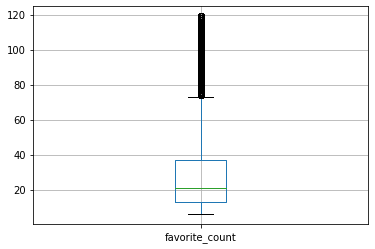

In [31]:
CleanData[['favorite_count']].boxplot()

In [32]:
#CleanData[['Post_len']].boxplot()

In [33]:
#remove ones that their posttext has less than 4 tokens
print(len(CleanData))
CleanData = CleanData[CleanData['Post_len'] > 5]
print(len(CleanData))

8017
8015


In [34]:
sentences = CleanData.post_text.values
print(type(sentences))
labels = CleanData.favorite_count.values
labels = [float(l) for l in labels]

<class 'numpy.ndarray'>


In [35]:
type(labels[0])

float

In [36]:
#testing the tokenizer
print('original= ', sentences[0])

print('Tokenized= ', tokenizer.tokenize(sentences[0]))

print('Token IDs= ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

print('encoded = ', tokenizer.encode(sentences[0], add_special_tokens=True))


original=  Manchester United must address Zlatan Ibrahimovic's lack of goals – video report
Tokenized=  ['manchester', 'united', 'must', 'address', 'z', '##lat', '##an', 'ibrahim', '##ovic', "'", 's', 'lack', 'of', 'goals', '–', 'video', 'report']
Token IDs=  [5087, 2142, 2442, 4769, 1062, 20051, 2319, 13477, 9142, 1005, 1055, 3768, 1997, 3289, 1516, 2678, 3189]
encoded =  [101, 5087, 2142, 2442, 4769, 1062, 20051, 2319, 13477, 9142, 1005, 1055, 3768, 1997, 3289, 1516, 2678, 3189, 102]


In [37]:
max_len = max(CleanData['Post_len'])

# for sentence in sentences:
    
#     encoded = tokenizer.encode(sentence, add_special_tokens=True)
    
#     max_len = max(max_len, len(encoded))
    
print(max_len)

52


In [38]:
#tokenize all of the sentences

input_ids = []
attention_masks = []

#for every sentece
for sent in sentences:
    encoded_input = tokenizer.encode_plus(
                            sent,
                            add_special_tokens= True,
                            max_length= max_len,
                            pad_to_max_length=True,
                            return_attention_mask= True,
                            return_tensors = 'pt')
    
    input_ids.append(encoded_input['input_ids'])
    
    
    attention_masks.append(encoded_input['attention_mask'])
 

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\amin\anaconda3\envs\hugging\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [39]:
input_ids[2].size()

torch.Size([1, 52])

In [40]:
   
#convert the lists into tensors
print(type(input_ids))
input_ids = torch.cat(input_ids, dim=0)
print(type(input_ids))    
    
attention_masks = torch.cat(attention_masks, dim=0)  
labels = torch.tensor(labels)

<class 'list'>
<class 'torch.Tensor'>


## 3.2 Training and Validation split
[home](#home)

In [41]:
#combine input data together
dataset = TensorDataset(input_ids, attention_masks, labels)


#create 90 percent for train and 10 for test
train_size = int(0.999 * len(dataset))
val_size = len(dataset) - train_size

#divide the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,006 training samples
    9 validation samples


In [42]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Fine Tuning Bert <a id = 'ftb'></a>
[home](#home)

In [43]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1, # The number of output labels--1 for regression.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    #cache_dir= '/local/data1/omidvar/codes/HG/transformercashe'
)

# Tell pytorch to run this model on the GPU.
model.cuda(device)

Downloading: 100%|██████████████████████████████████████████████████████████████████| 420M/420M [00:37<00:00, 11.7MB/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequen

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [44]:
# Get all of the model's parameters as a list of tuples.

params = list(model.named_parameters())



print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')


for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')


for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')


for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2 Optimizer 

In [45]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                 eps = 1e-8)

C:\Users\amin\anaconda3\envs\hugging\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [46]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 50

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3 Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

In [47]:
# Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)

def mean_squared(preds, labels):
    return mean_squared_error(labels, preds)

Helper function for formatting elapsed times as hh:mm:ss

In [48]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [49]:


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

shutil.rmtree("./saved")
os.makedirs("./saved")


# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    
    #Save the model
    if epoch_i % 1 == 0 and epoch_i != 0:
        os.makedirs('./saved/'+str(epoch_i))
        model.save_pretrained('./saved/'+str(epoch_i))
    
    
    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        #total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_accuracy += mean_squared(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 50 ========
Training...
  Batch    40  of    251.    Elapsed: 0:00:08.
  Batch    80  of    251.    Elapsed: 0:00:15.
  Batch   120  of    251.    Elapsed: 0:00:21.
  Batch   160  of    251.    Elapsed: 0:00:28.
  Batch   200  of    251.    Elapsed: 0:00:35.
  Batch   240  of    251.    Elapsed: 0:00:41.

  Average training loss: 915.50
  Training epcoh took: 0:00:43

Running Validation...
  Accuracy: 404.22
  Validation Loss: 404.22
  Validation took: 0:00:00

======== Epoch 2 / 50 ========
Training...
  Batch    40  of    251.    Elapsed: 0:00:07.
  Batch    80  of    251.    Elapsed: 0:00:14.
  Batch   120  of    251.    Elapsed: 0:00:20.
  Batch   160  of    251.    Elapsed: 0:00:27.
  Batch   200  of    251.    Elapsed: 0:00:34.
  Batch   240  of    251.    Elapsed: 0:00:41.

  Average training loss: 668.79
  Training epcoh took: 0:00:43

Running Validation...
  Accuracy: 344.18
  Validation Loss: 344.18
  Validation took: 0:00:00

======== Epoch 3 / 50 =======

  Batch    40  of    251.    Elapsed: 0:00:07.
  Batch    80  of    251.    Elapsed: 0:00:14.
  Batch   120  of    251.    Elapsed: 0:00:21.
  Batch   160  of    251.    Elapsed: 0:00:28.
  Batch   200  of    251.    Elapsed: 0:00:35.
  Batch   240  of    251.    Elapsed: 0:00:42.

  Average training loss: 239.48
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 127.06
  Validation Loss: 127.06
  Validation took: 0:00:00

======== Epoch 19 / 50 ========
Training...
  Batch    40  of    251.    Elapsed: 0:00:07.
  Batch    80  of    251.    Elapsed: 0:00:14.
  Batch   120  of    251.    Elapsed: 0:00:21.
  Batch   160  of    251.    Elapsed: 0:00:28.
  Batch   200  of    251.    Elapsed: 0:00:35.
  Batch   240  of    251.    Elapsed: 0:00:42.

  Average training loss: 228.93
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 129.85
  Validation Loss: 129.85
  Validation took: 0:00:00

======== Epoch 20 / 50 ========
Training...
  Batch    40  of    251.   

  Batch    40  of    251.    Elapsed: 0:00:07.
  Batch    80  of    251.    Elapsed: 0:00:14.
  Batch   120  of    251.    Elapsed: 0:00:21.
  Batch   160  of    251.    Elapsed: 0:00:28.
  Batch   200  of    251.    Elapsed: 0:00:35.
  Batch   240  of    251.    Elapsed: 0:00:42.

  Average training loss: 100.64
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 119.16
  Validation Loss: 119.16
  Validation took: 0:00:00

======== Epoch 36 / 50 ========
Training...
  Batch    40  of    251.    Elapsed: 0:00:07.
  Batch    80  of    251.    Elapsed: 0:00:14.
  Batch   120  of    251.    Elapsed: 0:00:21.
  Batch   160  of    251.    Elapsed: 0:00:28.
  Batch   200  of    251.    Elapsed: 0:00:35.
  Batch   240  of    251.    Elapsed: 0:00:42.

  Average training loss: 96.88
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 123.47
  Validation Loss: 123.47
  Validation took: 0:00:00

======== Epoch 37 / 50 ========
Training...
  Batch    40  of    251.    

In [77]:
#model = BertForSequenceClassification.from_pretrained('./saved')

In [78]:
with open('./Logs/training_stats', 'wb') as f:
    pickle.dump(training_stats, f)


with open('./Logs/training_stats', 'rb') as f:
    training_stats = pickle.load(f)
    
#model = BertForSequenceClassification.from_pretrained('./saved')

In [79]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats.to_csv('./Logs/training_stats.csv')

In [1]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=0.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

xticks_list = []
for i in range(len(training_stats)):
    xticks_list.append(i+1)

plt.xticks(xticks_list)

plt.savefig('./Logs/trainloss.jpg')

NameError: name 'sns' is not defined

# 5. Test Set <a id='ts'></a>
[home](#home)

In [5]:
epoch = 14

model_test = BertForSequenceClassification.from_pretrained('./saved/'+str(epoch))
tokenizer_test = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model_test = model_test.cuda()

In [6]:
def popularity_pred(model, tokenizer, sent, max_length = 104):

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 104,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_id = encoded_dict['input_ids']
    input_id = input_id.cuda()
    attention_mask = encoded_dict['attention_mask']
    attention_mask = attention_mask.cuda()
    model_test.eval()
    
    
    with torch.no_grad():
        result = model(input_id, 
                         token_type_ids=None, 
                         attention_mask=attention_mask,
                         return_dict=True)
    popularity = result.logits.data[0].item()
    a_max = 200
    a_min = 10
    if popularity > a_max:
        popularity = a_max
    elif popularity < a_min:
        popularity = a_min
    
    popularity = (popularity - a_min) / (a_max - a_min)
    
    return popularity

In [7]:
def popularity_pred_batch(model, tokenizer, sents, max_length = 104):
    input_ids = []
    attention_masks = []

    for sent in sents:

        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 104,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    #convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)  
    attention_masks = torch.cat(attention_masks, dim=0)  

    input_ids = input_ids.cuda()
    attention_masks = attention_masks.cuda()

    model.eval()


    with torch.no_grad():
        result = model(input_ids, 
                         token_type_ids=None, 
                         attention_mask=attention_masks,
                         return_dict=True)

    popularity = result.logits.data.tolist()
    
    
    a_max = 200
    a_min = 10
    if popularity > a_max:
        popularity = a_max
    elif popularity < a_min:
        popularity = a_min

    popularity = (popularity - a_min) / (a_max - a_min)
    print(popularity)
    return result


In [9]:
sent_idx = 1
sents = []

# sents.append(MergedData.post_text[sent_idx])
# print(MergedData.favorite_count[sent_idx])
# print(sents[0])


sents.append('Gunman kills at least 8 in mass shooting at California rail yard')

sents.append('Bitcoin is using lots of energy resources')
sents.append('CAD is using lots of energy resources')
sents.append('Trump is using lots of energy resources')
sents.append("What do you do? I'm scared!" )


In [10]:
input_ids = []
attention_masks = []

In [11]:
for sent in sents:

    encoded_dict = tokenizer_test.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 104,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\amin\anaconda3\envs\hugging\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
#convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)  
attention_masks = torch.cat(attention_masks, dim=0)  

input_ids = input_ids.cuda()
attention_masks = attention_masks.cuda()

model_test.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
with torch.no_grad():
    result = model_test(input_ids, 
                     token_type_ids=None, 
                     attention_mask=attention_masks,
                     return_dict=True)

popularity = result.logits.data.tolist()

In [ ]:
model_test?

In [19]:
print(result.logits.data.tolist())

[[0.013549785129725933], [0.15125782787799835], [0.03824256360530853], [0.15130363404750824], [0.12562473118305206]]


In [18]:
result.logits.data.tolist()

[[0.013549785129725933],
 [0.15125782787799835],
 [0.03824256360530853],
 [0.15130363404750824],
 [0.12562473118305206]]

In [ ]:
len(result.logits.data)

In [ ]:
print(popularity[0][0])

In [15]:
def normalize_minmax(popularity, a_min = 10, a_max = 200):
    if popularity > a_max:
        popularity = a_max
    elif popularity < a_min:
        popularity = a_min 
    popularity = (popularity - a_min) / (a_max - a_min)
    return(popularity)
        
n_popularity = []
for i in popularity:
    print(i)
    n_popularity.append(normalize_minmax(i[0]))


[12.574459075927734]
[38.73898696899414]
[17.26608657836914]
[38.74768829345703]
[33.86869812011719]


In [16]:
for i in range(len(result.logits.data )):
    result.logits.data[i] = normalize_minmax(result.logits.data[i])
print(result.logits.data)

tensor([[0.0135],
        [0.1513],
        [0.0382],
        [0.1513],
        [0.1256]], device='cuda:0')


In [ ]:
result.logits.data + 1 - result.logits.data

In [ ]:
baseline = [0.32, 0.10, 1, 0.5]

In [ ]:
baseline = torch.tensor(baseline)
baseline = baseline.cuda()
print(baseline)

In [ ]:
result.logits.data - baseline.view(4,1)

In [ ]:
print(result.logits.data.size())
print(baseline.view(4,1).size())

In [ ]:
print(n_popularity)

In [ ]:
n_popularity - baseline

In [ ]:
popularity = popularity_pred_batch(model_test, tokenizer_test, sents)

In [ ]:
print(popularity)

In [ ]:
popularity_pred(model_test, tokenizer_test, sents)

In [ ]:
for sent in sents:
    print(sent, popularity_pred(model_test, tokenizer_test, sent))

In [ ]:
tokenizer.encode_plus?

In [ ]:
torch.cat?

In [ ]:
import pickle
with open('./Logs/training_stats', 'rb') as f:
    training_stats = pickle.load(f)

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
# Display the table.
df_stats.to_csv('./Logs/training_stats.csv')

In [ ]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

xticks_list = []
for i in range(len(training_stats)):
    xticks_list.append(i+1)

plt.xticks(xticks_list)

plt.savefig('./Logs/trainloss.jpg')